In [1]:
from binance.client import Client
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
import warnings

api_key = 'haWzm6Ujj0SdpaCeCBiyyAvTvS78odvplgl4W9t29CVgSq5LrAHpt940JYQCt5TD'
secret_key = 'SgoyFqlJ6SvCYSXPFsU1ehPzQHhsfFV3Pa5scLF6y0stOO0aYXpfig6Fy4N0ePWX'
client = Client(api_key=api_key, api_secret=secret_key, tld='com')
account = client.get_account()

warnings.filterwarnings('ignore')
plt.style.use('dark_background')

In [2]:
class Long_Only_Backtester():
    ''' Class for the vectorized backtesting of simple Long-only trading strategies.
    
    Attributes
    ============
    filepath: str
        local filepath of the dataset (csv-file)
    symbol: str
        ticker symbol (instrument) to be backtested
    start: str
        start date for data import
    end: str
        end date for data import
    tc: float
        proportional trading costs per trade
    
    
    Methods
    =======
    get_data:
        imports the data.
        
    test_strategy:
        prepares the data and backtests the trading strategy incl. reporting (wrapper).
        
    prepare_data:
        prepares the data for backtesting.
    
    run_backtest:
        runs the strategy backtest.
        
    plot_results:
        plots the cumulative performance of the trading strategy compared to buy-and-hold.
        
    optimize_strategy:
        backtests strategy for different parameter values incl. optimization and reporting (wrapper).
    
    find_best_strategy:
        finds the optimal strategy (global maximum).
         
        
    print_performance:
        calculates and prints various performance metrics.
        
    '''    
    
    def __init__(self, filepath, symbol, start, end, tc):
        
        self.filepath = filepath
        self.symbol = symbol
        self.start = start
        self.end = end
        self.tc = tc
        self.results = None
        self.get_data()
        self.tp_year = (self.data.Close.count() / ((self.data.index[-1] - self.data.index[0]).days / 365.25))
        
    def __repr__(self):
        return "Long_Only_Backtester(symbol = {}, start = {}, end = {})".format(self.symbol, self.start, self.end)
        
    def get_data(self):
        ''' Imports the data.
        '''
        raw = pd.read_csv(self.filepath, parse_dates = ["Date"], index_col = "Date")
        raw = raw.loc[self.start:self.end].copy()
        raw["returns"] = np.log(raw.Close / raw.Close.shift(1))
        self.data = raw
        
    def test_strategy(self, percentiles = None, thresh = None):
        '''
        Prepares the data and backtests the trading strategy incl. reporting (Wrapper).
         
        Parameters
        ============
        percentiles: tuple (return_perc, vol_low_perc, vol_high_perc)
            return and volume percentiles to be considered for the strategy.
            
        thresh: tuple (return_thresh, vol_low_thresh, vol_high_thesh)
            return and volume thresholds to be considered for the strategy.
        '''
        
        self.prepare_data(percentiles = percentiles, thresh = thresh)
        self.run_backtest()
        
        data = self.results.copy()
        data["creturns"] = data["returns"].cumsum().apply(np.exp)
        data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
        self.results = data
        
        self.print_performance()
    
    def prepare_data(self, percentiles, thresh):
        ''' Prepares the Data for Backtesting.
        '''
        
        data = self.data[["Close", "Volume", "returns"]].copy()
        data["vol_ch"] = np.log(data.Volume.div(data.Volume.shift(1)))
        data.loc[data.vol_ch > 3, "vol_ch"] = np.nan
        data.loc[data.vol_ch < -3, "vol_ch"] = np.nan        
        
        if percentiles:
            self.return_thresh = np.percentile(data.returns.dropna(), percentiles[0])
            self.volume_thresh = np.percentile(data.vol_ch.dropna(), [percentiles[1], percentiles[2]])
        elif thresh:
            self.return_thresh = thresh[0]
            self.volume_thresh = [thresh[1], thresh[2]]
                
        cond1 = data.returns >= self.return_thresh
        cond2 = data.vol_ch.between(self.volume_thresh[0], self.volume_thresh[1])
        
        data["position"] = 1
        data.loc[cond1 & cond2, "position"] = 0

        self.results = data
    
    def run_backtest(self):
        ''' Runs the strategy backtest.
        '''
        
        data = self.results.copy()
        data["strategy"] = data["position"].shift(1) * data["returns"]
        data["trades"] = data.position.diff().fillna(0).abs()
        data.strategy = data.strategy + data.trades * self.tc
        
        self.results = data
    
    def plot_results(self):
        '''  Plots the cumulative performance of the trading strategy compared to buy-and-hold.
        '''
        if self.results is None:
            print("Run test_strategy() first.")
        else:
            title = "{} | TC = {}".format(self.symbol, self.tc)
            self.results[["creturns", "cstrategy"]].plot(title=title, figsize=(12, 8))
            
    def optimize_strategy(self, return_range, vol_low_range, vol_high_range, metric = "Multiple"):
        '''
        Backtests strategy for different parameter values incl. Optimization and Reporting (Wrapper).
         
        Parameters
        ============
        return_range: tuple
            tuples of the form (start, end, step size).
            
        vol_low_range: tuple
            tuples of the form (start, end, step size).
        
        vol_high_range: tuple
            tuples of the form (start, end, step size).
        
        metric: str
            performance metric to be optimized (can be "Multiple" or "Sharpe")
        '''
        
        self.metric = metric
        
        if metric == "Multiple":
            performance_function = self.calculate_multiple
        elif metric == "Sharpe":
            performance_function = self.calculate_sharpe
        
        return_range = range(*return_range)
        vol_low_range = range(*vol_low_range)
        vol_high_range = range(*vol_high_range)
        
        combinations = list(product(return_range, vol_low_range, vol_high_range))
        
        performance = []
        for comb in combinations:
            self.prepare_data(percentiles = comb, thresh = None)
            self.run_backtest()
            performance.append(performance_function(self.results.strategy))
    
        self.results_overview =  pd.DataFrame(data = np.array(combinations), columns = ["returns", "vol_low", "vol_high"])
        self.results_overview["performance"] = performance
        self.find_best_strategy()
        
        
    def find_best_strategy(self):
        ''' Finds the optimal strategy (global maximum).
        '''
        
        best = self.results_overview.nlargest(1, "performance")
        return_perc = best.returns.iloc[0]
        vol_perc = [best.vol_low.iloc[0], best.vol_high.iloc[0]]
        perf = best.performance.iloc[0]
        print("Return_Perc: {} | Volume_Perc: {} | {}: {}".format(return_perc, vol_perc, self.metric, round(perf, 5))) 
        self.test_strategy(percentiles = (return_perc, vol_perc[0], vol_perc[1]))
            
    ############################## Performance ######################################
    
    def print_performance(self):
        ''' Calculates and prints various Performance Metrics.
        '''
        
        data = self.results.copy()
        strategy_multiple = round(self.calculate_multiple(data.strategy), 6)
        bh_multiple =       round(self.calculate_multiple(data.returns), 6)
        outperf =           round(strategy_multiple - bh_multiple, 6)
        cagr =              round(self.calculate_cagr(data.strategy), 6)
        ann_mean =          round(self.calculate_annualized_mean(data.strategy), 6)
        ann_std =           round(self.calculate_annualized_std(data.strategy), 6)
        sharpe =            round(self.calculate_sharpe(data.strategy), 6)
       
        print(100 * "=")
        print("SIMPLE PRICE & VOLUME STRATEGY | INSTRUMENT = {} | THRESHOLDS = {}, {}".format(self.symbol, np.round(self.return_thresh, 5), np.round(self.volume_thresh, 5)))
        print(100 * "-")
        print("PERFORMANCE MEASURES:")
        print("\n")
        print("Multiple (Strategy):         {}".format(strategy_multiple))
        print("Multiple (Buy-and-Hold):     {}".format(bh_multiple))
        print(38 * "-")
        print("Out-/Underperformance:       {}".format(outperf))
        print("\n")
        print("CAGR:                        {}".format(cagr))
        print("Annualized Mean:             {}".format(ann_mean))
        print("Annualized Std:              {}".format(ann_std))
        print("Sharpe Ratio:                {}".format(sharpe))
        
        print(100 * "=")
        
    def calculate_multiple(self, series):
        return np.exp(series.sum())
    
    def calculate_cagr(self, series):
        return np.exp(series.sum())**(1/((series.index[-1] - series.index[0]).days / 365.25)) - 1
    
    def calculate_annualized_mean(self, series):
        return series.mean() * self.tp_year
    
    def calculate_annualized_std(self, series):
        return series.std() * np.sqrt(self.tp_year)
    
    def calculate_sharpe(self, series):
        if series.std() == 0:
            return np.nan
        else:
            return self.calculate_cagr(series) / self.calculate_annualized_std(series)


In [3]:
filepath = "bitcoin.csv"
symbol = "BTCUSDT"
start = "2017-08-17"
end = "2022-09-07"
tc = -0.00085

In [5]:
tester = Long_Only_Backtester(filepath=filepath,symbol=symbol, start=start, end=end, tc=tc)

In [6]:
tester

Long_Only_Backtester(symbol = BTCUSDT, start = 2017-08-17, end = 2022-09-07)

In [7]:
tester.data

,Open,High,Low,Close,Volume,returns
Date,,,,,,
2017-08-17 04:00:00,4261.48,4313.62,4261.32,4308.83,47.181009,NaN
2017-08-17 05:00:00,4308.83,4328.69,4291.37,4315.32,23.234916,0.001505
2017-08-17 06:00:00,4330.29,4345.45,4309.37,4324.35,7.229691,0.002090
2017-08-17 07:00:00,4316.62,4349.99,4287.41,4349.99,4.443249,0.005912
2017-08-17 08:00:00,4333.32,4377.85,4333.32,4360.69,0.972807,0.002457
...,...,...,...,...,...,...
2021-10-07 05:00:00,55073.20,55073.21,54545.07,54735.76,2251.122020,-0.006146
2021-10-07 06:00:00,54735.77,54968.06,54375.83,54534.16,1783.004260,-0.003690
2021-10-07 07:00:00,54534.16,54793.26,54235.33,54755.92,4163.431360,0.004058


In [8]:
tester.test_strategy(percentiles=(90,5,20))

SIMPLE PRICE & VOLUME STRATEGY | INSTRUMENT = BTCUSDT | THRESHOLDS = 0.00823, [-0.72895 -0.37604]
----------------------------------------------------------------------------------------------------
PERFORMANCE MEASURES:


Multiple (Strategy):         19.056163
Multiple (Buy-and-Hold):     12.53136
--------------------------------------
Out-/Underperformance:       6.524803


CAGR:                        1.03805
Annualized Mean:             0.712013
Annualized Std:              0.888775
Sharpe Ratio:                1.167957


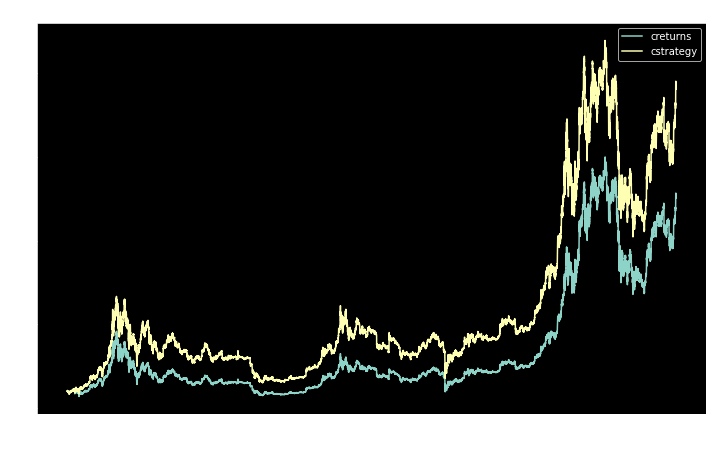

In [9]:
tester.plot_results()

In [11]:
tester.results

,Close,Volume,returns,vol_ch,position,strategy,trades,creturns,cstrategy
Date,,,,,,,,,
2017-08-17 04:00:00,4308.83,47.181009,NaN,NaN,1,NaN,0.0,NaN,NaN
2017-08-17 05:00:00,4315.32,23.234916,0.001505,-0.708335,1,0.001505,0.0,1.001506,1.001506
2017-08-17 06:00:00,4324.35,7.229691,0.002090,-1.167460,1,0.002090,0.0,1.003602,1.003602
2017-08-17 07:00:00,4349.99,4.443249,0.005912,-0.486810,1,0.005912,0.0,1.009552,1.009552
2017-08-17 08:00:00,4360.69,0.972807,0.002457,-1.518955,1,0.002457,0.0,1.012036,1.012036
...,...,...,...,...,...,...,...,...,...
2021-10-07 05:00:00,54735.76,2251.122020,-0.006146,0.439863,1,-0.006146,0.0,12.703161,19.317417
2021-10-07 06:00:00,54534.16,1783.004260,-0.003690,-0.233129,1,-0.003690,0.0,12.656373,19.246268
2021-10-07 07:00:00,54755.92,4163.431360,0.004058,0.848040,1,0.004058,0.0,12.707839,19.324531


In [12]:
return_thresh = tester.return_thresh
return_thresh

0.008231867023808183

In [13]:
volume_thresh = tester.volume_thresh
volume_thresh

array([-0.72895253, -0.37604441])

In [14]:
tester.test_strategy(thresh=(return_thresh, volume_thresh[0],volume_thresh[1]))

SIMPLE PRICE & VOLUME STRATEGY | INSTRUMENT = BTCUSDT | THRESHOLDS = 0.00823, [-0.72895 -0.37604]
----------------------------------------------------------------------------------------------------
PERFORMANCE MEASURES:


Multiple (Strategy):         19.056163
Multiple (Buy-and-Hold):     12.53136
--------------------------------------
Out-/Underperformance:       6.524803


CAGR:                        1.03805
Annualized Mean:             0.712013
Annualized Std:              0.888775
Sharpe Ratio:                1.167957


In [15]:
tester.optimize_strategy(return_range=(85,98,1),
                        vol_low_range=(2,16,1),
                        vol_high_range=(16,35,1))

Return_Perc: 94 | Volume_Perc: [12, 27] | Multiple: 30.04924
SIMPLE PRICE & VOLUME STRATEGY | INSTRUMENT = BTCUSDT | THRESHOLDS = 0.01168, [-0.5182  -0.28115]
----------------------------------------------------------------------------------------------------
PERFORMANCE MEASURES:


Multiple (Strategy):         30.049242
Multiple (Buy-and-Hold):     12.53136
--------------------------------------
Out-/Underperformance:       17.517882


CAGR:                        1.275079
Annualized Mean:             0.822038
Annualized Std:              0.893157
Sharpe Ratio:                1.427608


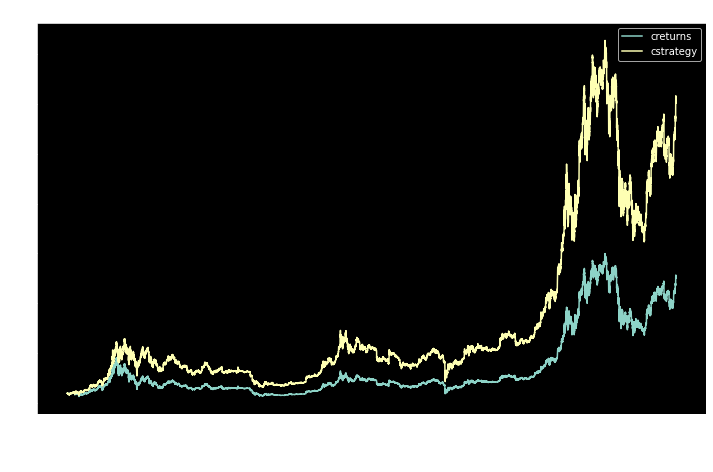

In [16]:
tester.plot_results()

In [17]:
symbol = "BTCUSDT"
start = "2017-08-17"
end = "2020-12-31"
tc = -0.00085

In [19]:
tester = Long_Only_Backtester(filepath="bitcoin.csv", symbol=symbol,start=start,end=end,tc=tc)
tester

Long_Only_Backtester(symbol = BTCUSDT, start = 2017-08-17, end = 2020-12-31)

In [20]:
tester.optimize_strategy((85,98,1),(2,16,1),(16,35,1))

Return_Perc: 94 | Volume_Perc: [12, 28] | Multiple: 17.68849
SIMPLE PRICE & VOLUME STRATEGY | INSTRUMENT = BTCUSDT | THRESHOLDS = 0.01107, [-0.52736 -0.27342]
----------------------------------------------------------------------------------------------------
PERFORMANCE MEASURES:


Multiple (Strategy):         17.688488
Multiple (Buy-and-Hold):     6.712641
--------------------------------------
Out-/Underperformance:       10.975847


CAGR:                        1.343699
Annualized Mean:             0.851759
Annualized Std:              0.887773
Sharpe Ratio:                1.513561


In [22]:
many_results = tester.results_overview
many_results

,returns,vol_low,vol_high,performance
0,85,2,16,9.508650
1,85,2,17,10.473487
2,85,2,18,11.026611
3,85,2,19,11.934646
4,85,2,20,12.115648
...,...,...,...,...
3453,97,15,30,8.572045
3454,97,15,31,9.262247
3455,97,15,32,8.490958
3456,97,15,33,7.860362


<AxesSubplot:xlabel='returns'>

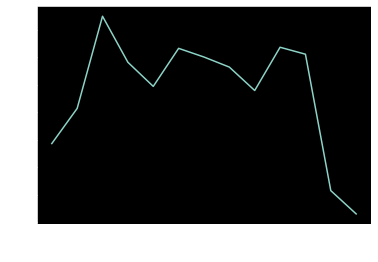

In [23]:
many_results.groupby("returns").performance.mean().plot()

<AxesSubplot:xlabel='vol_low'>

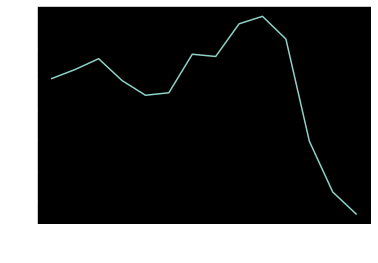

In [26]:
many_results.groupby("vol_low").performance.mean().plot()

<AxesSubplot:xlabel='vol_high'>

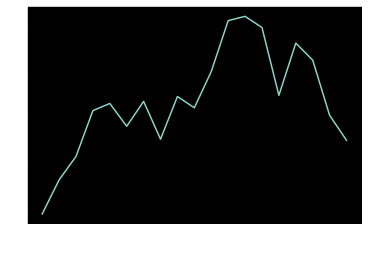

In [25]:
many_results.groupby("vol_high").performance.mean().plot()


In [28]:
tester.test_strategy((94, 11, 28))

SIMPLE PRICE & VOLUME STRATEGY | INSTRUMENT = BTCUSDT | THRESHOLDS = 0.01107, [-0.55039 -0.27342]
----------------------------------------------------------------------------------------------------
PERFORMANCE MEASURES:


Multiple (Strategy):         17.284017
Multiple (Buy-and-Hold):     6.712641
--------------------------------------
Out-/Underperformance:       10.571376


CAGR:                        1.327681
Annualized Mean:             0.844901
Annualized Std:              0.887162
Sharpe Ratio:                1.496549


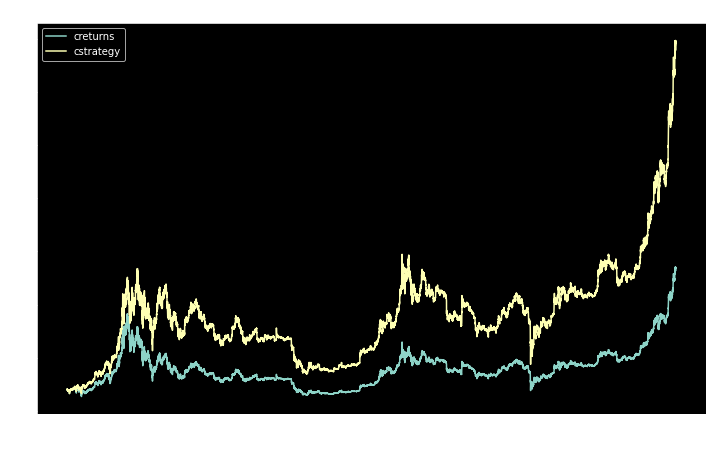

In [29]:
tester.plot_results()

In [30]:
return_thresh = tester.return_thresh
return_thresh

0.011069826844302733

In [31]:
volume_thresh = tester.volume_thresh
volume_thresh

array([-0.55039207, -0.27342444])

In [32]:
# Starting forward testing

In [34]:
filepath = "bitcoin.csv"
symbol = "BTCUSDT"
start = "2021-01-01"
end = "2021-10-7"
tc = -0.00085

In [36]:
tester = Long_Only_Backtester(filepath=filepath,symbol=symbol,start=start,end=end,tc=tc)
tester

Long_Only_Backtester(symbol = BTCUSDT, start = 2021-01-01, end = 2021-10-7)

In [37]:
tester.test_strategy(thresh=(return_thresh,volume_thresh[0],volume_thresh[1]))

SIMPLE PRICE & VOLUME STRATEGY | INSTRUMENT = BTCUSDT | THRESHOLDS = 0.01107, [-0.55039 -0.27342]
----------------------------------------------------------------------------------------------------
PERFORMANCE MEASURES:


Multiple (Strategy):         1.685544
Multiple (Buy-and-Hold):     1.862227
--------------------------------------
Out-/Underperformance:       -0.176683


CAGR:                        0.980771
Annualized Mean:             0.683588
Annualized Std:              0.911607
Sharpe Ratio:                1.075871


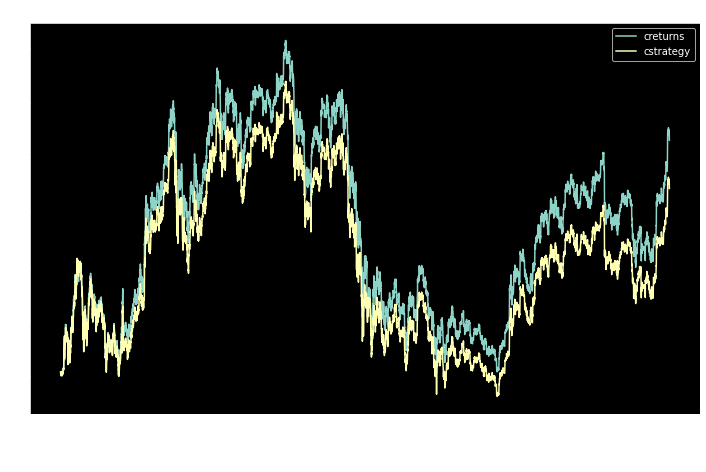

In [39]:
tester.plot_results()

In [41]:
tester.results.position.value_counts()

1    6635
0      58
Name: position, dtype: int64

In [42]:
tester.optimize_strategy((85,98,1),(5,15,1),(15,35,1))

Return_Perc: 91 | Volume_Perc: [10, 15] | Multiple: 2.0269
SIMPLE PRICE & VOLUME STRATEGY | INSTRUMENT = BTCUSDT | THRESHOLDS = 0.01094, [-0.5274  -0.42192]
----------------------------------------------------------------------------------------------------
PERFORMANCE MEASURES:


Multiple (Strategy):         2.026904
Multiple (Buy-and-Hold):     1.862227
--------------------------------------
Out-/Underperformance:       0.164677


CAGR:                        1.521666
Annualized Mean:             0.925058
Annualized Std:              0.917706
Sharpe Ratio:                1.658119


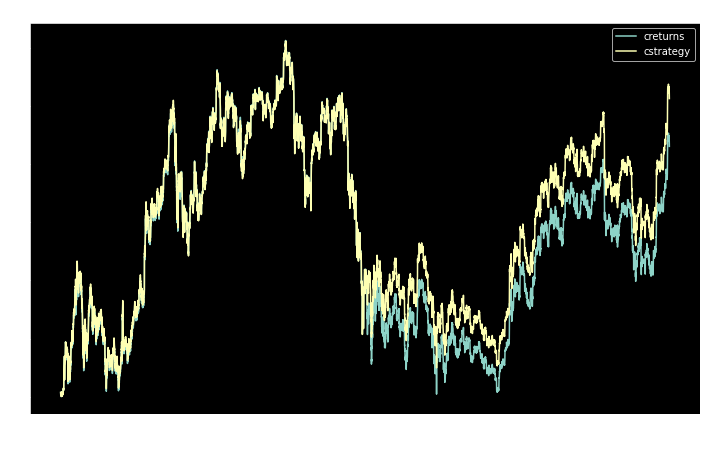

In [43]:
tester.plot_results()